In [158]:
import spacy
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import json
import spacy_stanza
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import torch
import stanza
from thinc.api import get_current_ops

In [153]:
# DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# get_current_ops()

In [162]:
with open('corpus.json', 'r') as file:
  raw_corpus = json.load(file)

flat_corpus = []
for video in raw_corpus:
  youtube_id = video['id']
  youtube_title = video['title']
  youtube_text = video['text']
  flat_corpus.append({
    'id': youtube_id,
    'title': youtube_title,
    'text': youtube_text
  })

df = pd.DataFrame(flat_corpus)
df.reset_index(drop=True, inplace=True)

spacy.require_gpu()
# nlp = spacy.load("en_core_web_sm")
nlp = spacy_stanza.load_pipeline('id')


2024-07-02 13:32:13 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-07-02 13:32:15 INFO: Loading these models for language: id (Indonesian):
| Processor    | Package      |
-------------------------------
| tokenize     | gsd          |
| mwt          | gsd          |
| pos          | gsd_charlm   |
| lemma        | gsd_nocharlm |
| constituency | icon_charlm  |
| depparse     | gsd_charlm   |

2024-07-02 13:32:15 WARNING: GPU requested, but is not available!
2024-07-02 13:32:15 INFO: Using device: cpu
2024-07-02 13:32:15 INFO: Loading: tokenize
2024-07-02 13:32:15 INFO: Loading: mwt
2024-07-02 13:32:15 INFO: Loading: pos
2024-07-02 13:32:15 INFO: Loading: lemma
2024-07-02 13:32:15 INFO: Loading: constituency
2024-07-02 13:32:15 INFO: Loading: depparse
2024-07-02 13:32:15 INFO: Done loading processors!


In [147]:
def custom_tokenizer(doc):
    stripped_text = doc.strip()
    duplicated_letter_pattern = re.compile(r'^(.)\1+$')
    tokens = []
    
    for t in nlp(stripped_text):
        # Fix this later. Because this is hardcoded for text with length = 2 to remove all of nonsense <2 length char
        if t.text == 'ya' and t.text == 'oh':
            tokens.append(t.text)
        if len(t.text) > 2 and (not t.is_punct) and (not t.is_stop) and t.is_alpha and (not duplicated_letter_pattern.match(t.text)):
            tokens.append(t.lemma_)
    
    return tokens

In [148]:
custom_stop_words = ["[Musik]", "[Tepuk tangan]"]

for word in custom_stop_words:
  nlp.Defaults.stop_words.add(word)
  
transcripts = df["text"].tolist()

# vectorizer = CountVectorizer(tokenizer=custom_tokenizer, binary=True, lowercase=False, ngram_range=(1,2))
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, binary=True)
bow = vectorizer.fit_transform(transcripts)
bow.toarray()

print(cosine_similarity(bow))

/opt/homebrew/Caskroom/miniconda/base/envs/analysis/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# words_with_zaman = [word for word in vectorizer.vocabulary_ if ' ' in word]
# print(words_with_zaman)
feature_names = vectorizer.get_feature_names_out()
pd.set_option('display.max_rows', None)
short_feature = [text for text in feature_names if len(text) == 2]
df = pd.DataFrame(short_feature, columns=["Feature"])
df

,Feature


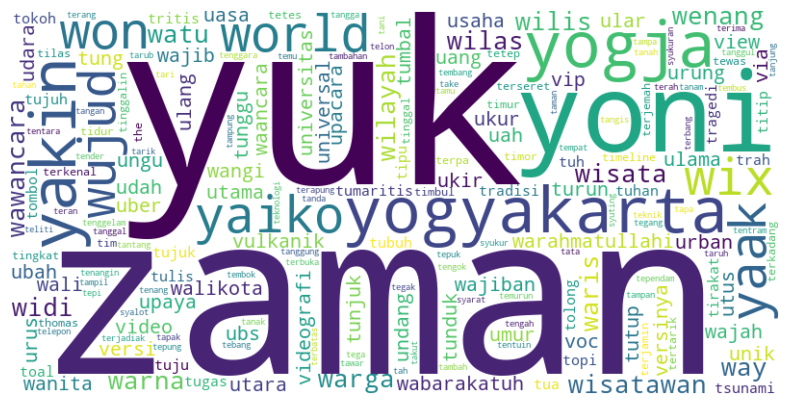

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vectorizer.vocabulary_)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()